<a href="https://colab.research.google.com/github/magistery-tps/dm-cyt-tp2/blob/main/notebooks/create_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####  Referencias

* [Pandas pipelines](https://calmcode.io/pandas-pipe/end.html)
* [Python logger](https://www.youtube.com/watch?v=g8nQ90Hk328&list=PLi01XoE8jYohWFPpC17Z-wWhPOSuh8Er-&index=17)
* [Dataset](https://smallworldofwords.org/en/project/research)
* [Glove word embedding](https://nlp.stanford.edu/projects/glove/)
* [Elmo word embedding](https://allennlp.org/elmo)
* [Basics of Using Pre-trained GloVe Vectors in Python](https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db)

####  Ejemplos

* [Ejemplo word2vect](https://colab.research.google.com/drive/1YcplHjDL1M6G9K62W4GyUbic0OxOt8GZ?usp=sharing)
* [Ejemplo carga de dataset](https://colab.research.google.com/drive/1Qlq56GM6xERVpy6FAJhS5XCqaAKGlGtD?usp=sharing)
* [Análisis de Redes](https://colab.research.google.com/drive/1ef-fnqmPsAxqlIc_ZrBXa0Fg6IYYf_g_?usp=sharing)

In [12]:
from IPython.display import clear_output
import sys
import os.path
from os import path

def is_runing_into_colab_env():
    try:
        import google.colab
        return True
    except:
        return False

### 1. Instalacion de paquetes

Bajo paquete para trabajar con EEG- Me permite ver la topografía

In [13]:
if is_runing_into_colab_env(): 
    !pip install rich
    !pip install networkx

In [14]:
%matplotlib inline
%load_ext autoreload
%load_ext rich
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rich extension is already loaded. To reload it, use:
  %reload_ext rich


###  2. Descargar dataset

Se descarga el dataset y lo descomprime en `~/datasets`.

In [15]:
dataset_filename = "SWOW-EN.R100.csv"
embeding_filename = "glove.840B.300d"
embeding_filename_txt = embeding_filename + '.txt'

dataset_url  = 'https://raw.githubusercontent.com/magistery-tps/dm-cyt-tp2/main/datasets/{}.zip'.format(dataset_filename)
embeding_url = 'https://nlp.stanford.edu/data/{}.zip'.format(embeding_filename)

if is_runing_into_colab_env():
    !cd ~
    !rm -rf datasets
    !rm -rf *.zip
    !wget  {dataset_url}
    !wget  {embeding_url}
    !unzip {dataset_filename}.zip
    !unzip {embeding_filename}.zip
    !mkdir datasets
    !mv {dataset_filename} datasets
    !mv {embeding_filename}.txt datasets
    !rm *.zip

###  3. Importa libreria del proyecto

In [16]:
if is_runing_into_colab_env():
    if path.exists('/content/dm-cyt-tp2'):
        print('Pull...\n')
        !cd dm-cyt-tp2; git pull origin main
    else:
        print('Clone...\n')
        !git clone https://github.com/magistery-tps/dm-cyt-tp2.git

In [17]:
sys.path.append('/content/dm-cyt-tp2/src' if is_runing_into_colab_env() else '../src')
dataset_path = '/content/datasets/{}' if is_runing_into_colab_env() else '../datasets/{}'

###  4. Importa paquetes externos

In [49]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import pandas as pd
import networkx as nx

import logging
from logger import setup_logger

from scipy.spatial.distance import euclidean, jaccard, cosine
from distance import closest, show_closest, distance

from step import  select_columns, \
                  rename_columns, \
                  filter_bidiredtional_associations, \
                  filter_words_lt, \
                  filter_stopwords, \
                  to_unique_works, \
                  to_work_embeddings, \
                  lower, \
                  strip, \
                  dropna, \
                  plot_frequency, \
                  log_unique_words, \
                  log_source_into_response_and_vise_versa, \
                  n_top, \
                  all_columns_contains, \
                  append_distance


from graph import graph_summary, graph_edges

In [19]:
setup_logger(format = '%(levelname)s: %(message)s')

###  5. Preprocesar dataset

En este paso seleccionamos las columnas **cue** y **R1**, las renombramos a **source** y **response**. Luego minisculizamos y quitamos espacios. Filtramos las palabras de menos de 2 letras, filtramos las filas con nulos. Por último filtramos stop words por varios lenguajes.

In [20]:
def load_dataset(filename): return pd.read_csv(dataset_path.format(filename))

In [21]:
dataset = load_dataset(dataset_filename) \
    .pipe(select_columns) \
    .pipe(rename_columns, {'cue': 'source', 'R1': 'response'}) \
    .pipe(lower) \
    .pipe(strip) \
    .pipe(log_unique_words) \
    .pipe(log_source_into_response_and_vise_versa, unique=True) \
    .pipe(log_source_into_response_and_vise_versa, unique=False) \
    .pipe(filter_words_lt, size_less_than=2) \
    .pipe(dropna) \
    .pipe(filter_stopwords, column = 'source') \
    .pipe(filter_stopwords, column = 'response')

INFO: (1228200, 13) --> select_columns({}) --> (1228200, 2)
INFO: (1228200, 2) --> rename_columns({}) --> (1228200, 2)
INFO: (1228200, 2) --> lower({}) --> (1228200, 2)
INFO: (1228200, 2) --> strip({}) --> (1228200, 2)
INFO: Unique - Source: 12282, Response: 63715
INFO: Unique: True, Source into response: 1104304, Response into source: 1219500
INFO: Unique: False, Source into response: 123896, Response into source: 8700
INFO: (1228200, 2) --> filter_words_lt({'size_less_than': 2}) --> (1225128, 2)
INFO: (1225128, 2) --> dropna({}) --> (1194119, 2)
INFO: (1194119, 2) --> filter_stopwords({'languages': ['arabic']}) --> (1194119, 2)
INFO: (1194119, 2) --> filter_stopwords({'languages': ['azerbaijani']}) --> (1193633, 2)
INFO: (1193633, 2) --> filter_stopwords({'languages': ['bengali']}) --> (1193633, 2)
INFO: (1193633, 2) --> filter_stopwords({'languages': ['danish']}) --> (1191959, 2)
INFO: (1191959, 2) --> filter_stopwords({'languages': ['dutch']}) --> (1190828, 2)
INFO: (1190828, 2) --

###  6. Generar un dicionario de embedding a partir de Glove

A continuacion se genera un diccionario donde la calse es una palabra y el valor es un vector embedding. Ademas solo genermos este doccionario para las palabar que se encuentran en el dataset inicial.

In [22]:
work_embeddings = dataset \
    .pipe(to_unique_works) \
    .pipe(to_work_embeddings, file_path = dataset_path.format(embeding_filename_txt))

INFO: (1135308, 2) --> to_unique_works({}) --> (462916, 1)


  0%|          | 0/462916 [00:00<?, ?it/s]

INFO: Found 5709 words.
INFO: (462916, 1) --> to_work_embeddings({'file_path': '../datasets/glove.840B.300d.txt'}) --> 5709


Finalmente filtramos el dataset para que tengo solamante palabras que existan en el embeding, nos quedamos con las filas para las cuales exista su par (Para (a, b) existe un par (b,a)). Finalmente se grafica la frecuencia de palabras para cada columna. 

INFO: (1843, 2) --> filter_bidiredtional_associations({}) --> (1223, 2)


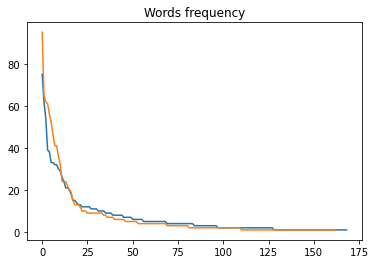

In [23]:
dataset = dataset \
    .pipe(all_columns_contains, words = work_embeddings.keys()) \
    .pipe(filter_bidiredtional_associations) \
    .pipe(plot_frequency, column = 'source') \
    .pipe(plot_frequency, column = 'response')

In [24]:
dataset.shape

(1223, 2)

### 7. Calcular distancias

Calculamos la distancias de una palabra elegida al azar contra todas las demas palabras del diccionario. Luego nos quedamos con el top 10 de las palabras mas cercanas.

In [25]:
any_word = list(work_embeddings.keys())[10]
any_word2 = list(work_embeddings.keys())[11]

show_closest(work_embeddings, any_word, cosine)
show_closest(work_embeddings, any_word, euclidean)
show_closest(work_embeddings, any_word, jaccard)

INFO: - distance: cosine
INFO: - Word: alternative
INFO: - Closest: ['preferable', 'affordable', 'straightforward', 'mainstream', 'sustainable', 'regardless', 'marketplace', 'framework', 'guidelines']
INFO: - distance: euclidean
INFO: - Word: alternative
INFO: - Closest: ['preferable', 'straightforward', 'regardless', 'affordable', 'mainstream', 'mainstay', 'drawback', 'forefront', 'alongside']
INFO: - distance: jaccard
INFO: - Word: alternative
INFO: - Closest: ['jetliner', 'dealbreaker', 'goldeneye', 'shipmate', 'penknife', 'masterbedroom', 'stairstep', 'serverfarm', 'website']


In [26]:
distance(work_embeddings, any_word, any_word2, euclidean)

8.361441612243652

### 8. Transformar a grafos

A continacion tomamos por un lado **dataset** (el cual tiene las columnas pregunta y respuesta) y por el otro el diccionario de **word_embeddings** y finalmente convertimos ambos datasets en grafos.

Creamos un dataset pesado por la distancia coseno entre las palabras fitlradas desde **Small World of Words**:

In [27]:
dataset = dataset \
    .pipe(append_distance, work_embeddings, cosine) \
    .pipe(rename_columns, {'cosine': 'weight'})

dataset

INFO: (1223, 3) --> append_distance({}) --> (1223, 3)
INFO: (1223, 3) --> rename_columns({}) --> (1223, 3)


,source,response,weight
30,sunday,sunday,0.000000
4110,sunday,sunday,0.000000
15865,photograph,snapshot,0.602729
21283,sunday,homework,0.596469
50440,photograph,snapshot,0.602729
...,...,...,...
1224286,boyfriend,girlfriend,0.141456
1224290,daytime,nighttime,0.222926
1226049,database,spreadsheet,0.481167
1227088,trademark,copyright,0.495920


Creamos un grafo pesado:

In [38]:
weighted_graph = nx.from_pandas_edgelist(dataset, 'source',  'response', 'weight', create_using=nx.Graph())

Graph with 180 nodes and 237 edges
Is weigthed: True


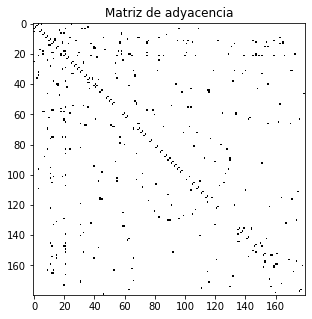

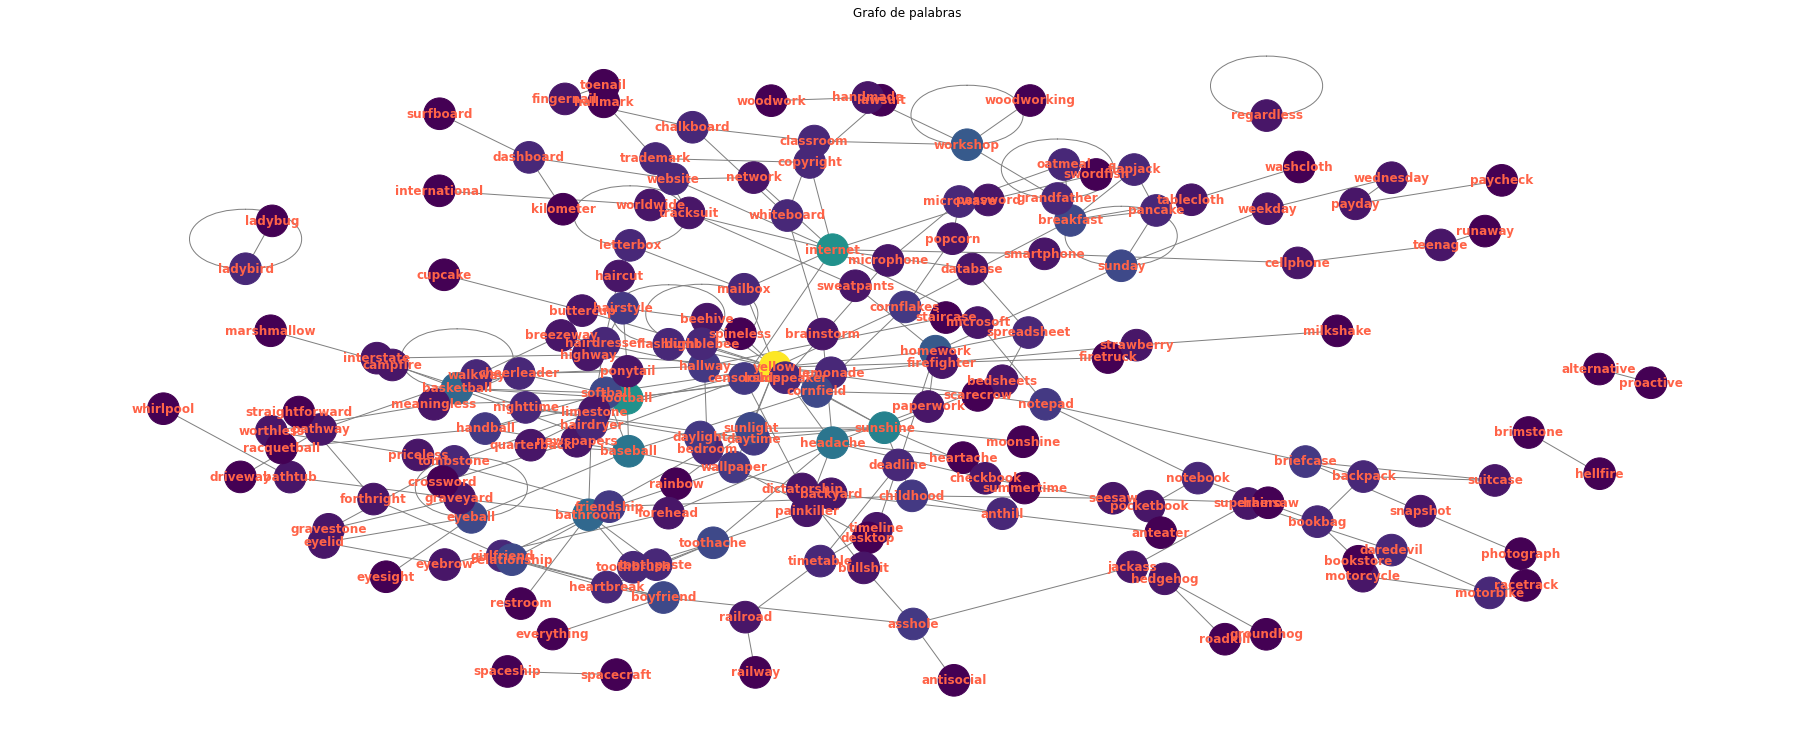

In [47]:
graph_summary(weighted_graph)

Creamos un grafo de interaccion, es decir no pesado:

In [43]:
interaction_graph = nx.from_pandas_edgelist(dataset, 'source',  'response', create_using=nx.Graph())

Graph with 180 nodes and 237 edges
Is weigthed: False


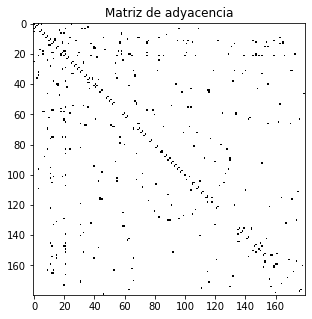

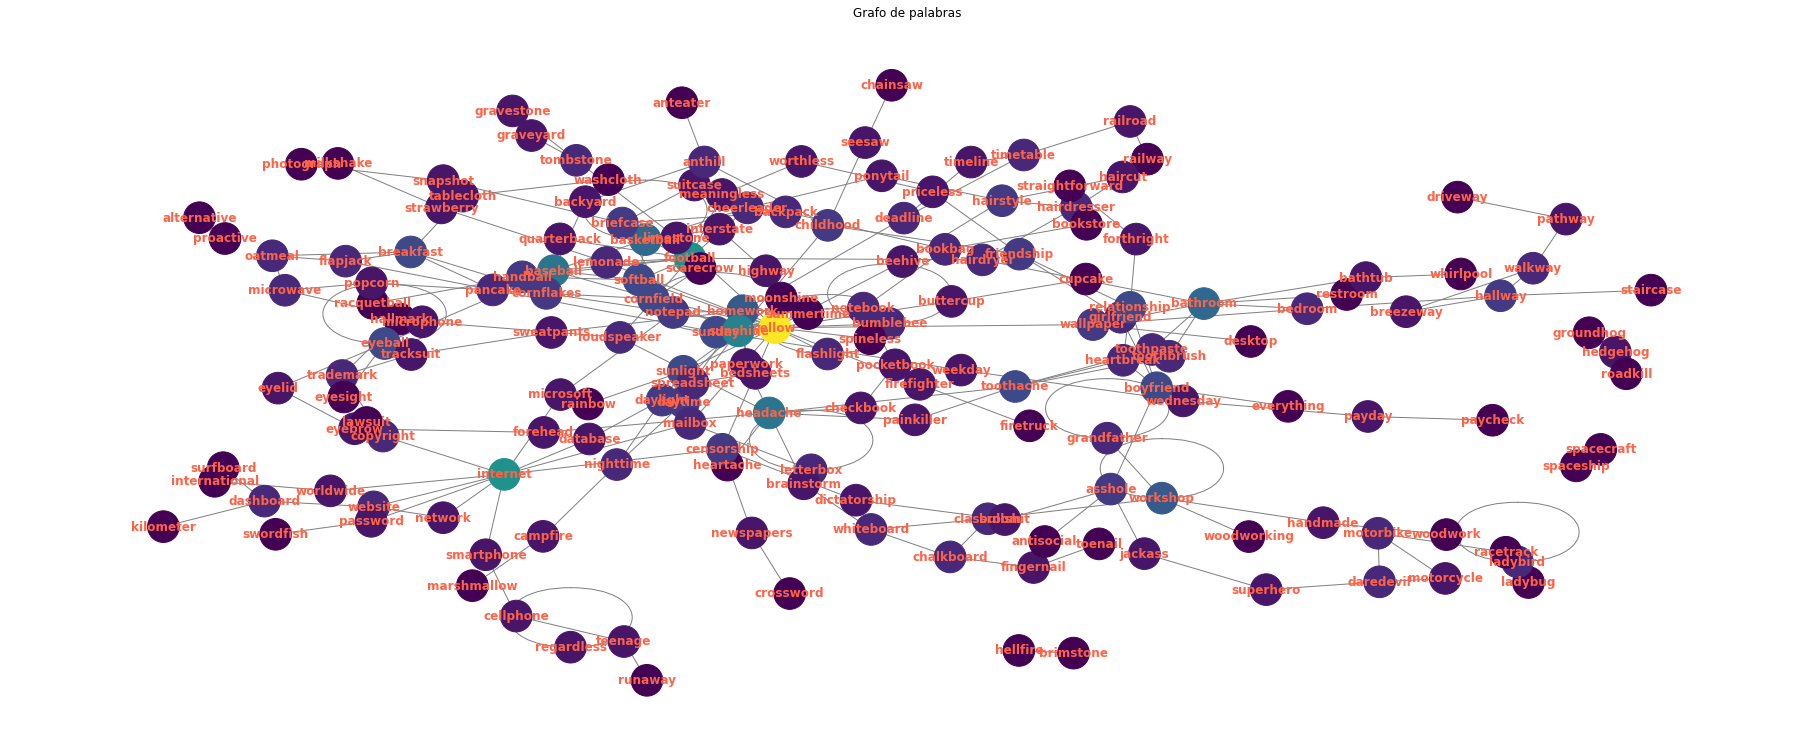

In [53]:
graph_summary(interaction_graph)